In [4]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans

In [5]:
plt.rcParams['figure.figsize'] = [20, 10]
fichier = 'CI RetV.png'

In [6]:
im = cv.imread(fichier)

# Class to manage points
class Point: 
    def __init__(self, x, y): 
        self.x = x 
        self.y = y 
    def print_coord(self):
        print('Point ({},{})'.format(self.x, self.y))

# Class to manage rectanges
class Rectangle:
    def __init__(self, l, r): 
        self.l = l 
        self.r = r 
        
    def print_coord(self):
        print('Rect TL({},{}) | Rect BR({},{})'.format(self.l.x, self.l.y, self.r.x, self.r.y))
    
    def getTopLeftPointCoord(self):
        return (self.l.x, self.l.y)
    
    def getBottomRightPointCoord(self):
        return (self.r.x, self.r.y)

    def getTopLeftPoint(self):
        return self.l
    
    def getBottomRightPoint(self):
        return self.r

# This function prepare the image, and detect all its contours, then filter the list of contours to return the contours list.
def getContoursFromImageFile(_fileimg):
    imgray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
    grayf = cv.GaussianBlur(imgray, (5, 5), 1)
    edged = cv.Canny(grayf, 0, 50)
    ret, thresh = cv.threshold(edged, 127, 255, 0)
    contours, hierarchy = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
    contours = sorted(contours, key=cv.contourArea, reverse=True)
    
    # Now filter the number of contours / restrict to the parents only
    onlyParents = []
    for i in range(hierarchy.shape[1]):
        if (hierarchy[0][i][3] < 0):
            onlyParents.append(contours[i])

    # Now restrict the number of points per contours
    flatlist = []
    limit = 3
    for i in range(len(onlyParents)):
        if (len(onlyParents[i]) < 4):
            limit = len(onlyParents[i])
        for j in range(limit):
            flatlist.append(onlyParents[i][j])
    
    # return a dataframe :
    points = prepareDataForClustering(flatlist)
    
    return points

# return a ready to fit dataframe with contours points
def prepareDataForClustering(data):
    X = pd.DataFrame(columns=['X', 'Y'])
    s = 0
    for i in range(len(data)):
        X.loc[s, 'X'] = data[i][0][0]
        X.loc[s, 'Y'] = data[i][0][1]
        s = s + 1
    return X

# return the Rectangle which include the all the points into the cluster
def getRectFromCluster(X, y, cluster):
    X0hg, Y0hg = 500000, 500000
    X0bd, Y0bd = 0, 0
    for index, point in X.iterrows():
        if (y.loc[index, 0]==cluster):
            if (X.loc[index, 'X'] < X0hg):
                X0hg = X.loc[index, 'X']
            elif (X.loc[index, 'X'] > X0bd):
                X0bd = X.loc[index, 'X']
            if (X.loc[index, 'Y'] < Y0hg):
                Y0hg = X.loc[index, 'Y']
            elif (X.loc[index, 'Y'] > Y0bd):
                Y0bd = X.loc[index, 'Y']
    return (int(X0hg), int(Y0hg)), (int(X0bd), int(Y0bd))

# Return the list of Rectangles which include each clusters
def getRectByCluster(c, contours):
    # Apply KMeans to the nb of cluster in input
    if (c is None):
        kmeans = KMeans()
    else:
        kmeans = KMeans(n_clusters=c)
    kmeans.fit(contours)
    
    y = pd.DataFrame(kmeans.labels_)
    ClusterMax = y.max()[0]
    print("Cluster(s)", ClusterMax+1)
    
    p1 = [] # points Haut à gauche
    p2 = [] # points Bas à droite
    for i in range(ClusterMax+1):
        A, B = getRectFromCluster(contours, y, i)
        p1.append(A)
        p2.append(B)
    
    # Set the rectangles to objects
    rs = []
    for i in range(ClusterMax+1):
        rs.append(Rectangle(Point(p1[i][0], p1[i][1]), Point(p2[i][0], p2[i][1])))
    return rs,  ClusterMax+1

# Returns true if two rectangles(l1, r1) and (l2, r2) overlap 
def RectOverlap(R1, R2): 
    if(R1.getTopLeftPoint().x >= R2.getBottomRightPoint().x or R2.getTopLeftPoint().x >= R1.getBottomRightPoint().x): 
        return False
    if(R1.getTopLeftPoint().y >= R2.getBottomRightPoint().y or R2.getTopLeftPoint().y >= R1.getBottomRightPoint().y): 
        return False
    return True

# Overlap detection between rectangles and returns True if there's at least one overlap
def hasOverlap(rectangles):
    ClusterMax = len(rectangles)
    for i in range(ClusterMax+1):
        for j in range(i+1, ClusterMax):
            if (RectOverlap(rectangles[i], rectangles[j])):
                #print("Overlap between Rectangles {0} and {1}".format(i, j))
                return True
    print("No Overlap !")
    return False

# Find the best clustering parameters and returns the final rectangles
def findBestClustering(r):
    endOfSearch = False
    nbCluster = None
    while (endOfSearch == False):
        rects, nbCluster = getRectByCluster(nbCluster, r)
        if (nbCluster == 1):
            print ("Only one cluster !")
            endOfSearch = True
        elif (hasOverlap(rects)):
            nbCluster = nbCluster - 1
        else:
            print ("Best cluster found", nbCluster)
            endOfSearch = True
    # Returns the rectangles
    r, n = getRectByCluster(nbCluster, contours)
    return n, r


# Crop the image given a rectangle
def cropImage (image, R):
    return image[R.l.y:R.r.y, R.l.x:R.r.x]

In [7]:
contours = getContoursFromImageFile(im)

In [8]:
nbcluster, rects = findBestClustering(contours)

Cluster(s) 8
Cluster(s) 7
Cluster(s) 6
Cluster(s) 5
Cluster(s) 4
Cluster(s) 3
Cluster(s) 2
No Overlap !
Best cluster found 2
Cluster(s) 2


In [9]:
nbcluster

2

In [10]:
rects

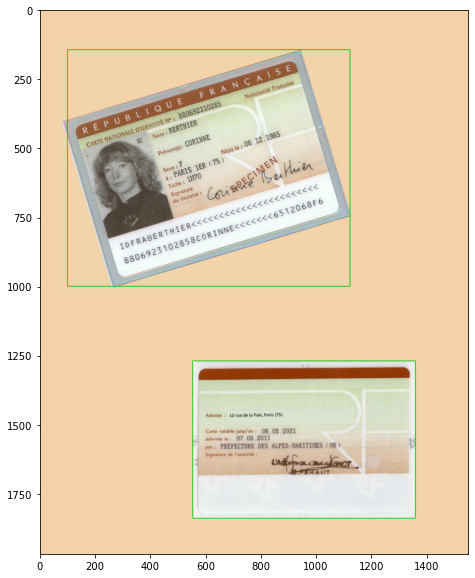

In [11]:
test = im.copy()
for i in range(nbcluster):
    test = cv.rectangle(test, rects[i].getTopLeftPointCoord(), rects[i].getBottomRightPointCoord(), (0,200,0), 2)
plt.rcParams['figure.figsize'] = [20, 10]
plt.imshow(test)

In [11]:
for i in range(nbcluster):
    cv.imwrite('C' + str(i) + '.jpg', cropImage(im.copy(), rects[i]))